<div style="border:solid green 2px; padding: 20px">
<b>Привет, Владислав!</b>

Меня зовут Александр Пономаренко, и я буду проверять твой проект. Предлагаю общаться на «ты» :) Но если это не удобно - дай знать, и мы перейдем на "вы". 

Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать data science. Ты уже проделал большую работу над проектом, но давай сделаем его еще лучше. Ниже ты найдешь мои комментарии - **пожалуйста, не перемещай, не изменяй и не удаляй их**. Увидев у тебя ошибку, в первый раз я лишь укажу на ее наличие и дам тебе возможность самой найти и исправить ее. На реальной работе твой начальник будет поступать так же, а я пытаюсь подготовить тебя именно к работе аналитиком. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> Так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Так выделены небольшие замечания. Я надеюсь, что их ты тоже учтешь - твой проект от этого станет только лучше. Но настаивать на их отработке не буду.

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Так я выделяю все остальные комментарии.</div>

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте или отвечаешь на мои комменатри — пиши об этом.** Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 

## Outline

- Outline
- Project description
- Describe data
- Initialize spark session
- Check if local or web + load data
- Inspect data
- Clean data
  - Missing data - delete/fill/leave
  - Convert categorical data with OHE
- Test two ML models
  - Use all data
  - Use only numerical data
- Compare results using RMSE, MAE, R2 metrics
- Conclusion

## Project description

The data recieved are prices and description of houses. We need to train model that will best predict house price.

## Describe data

- longitude
- latitude
- housing_median_age
- total_rooms
- total_bedrooms
- population
- households - number of houses in one residential area
- median_income - for residential area
- median_house_value - target
- ocean_proximity

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022

## Initialize spark session

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Spark Yandex Practicum") \
                    .getOrCreate()

## Check if local or web + load data

In [3]:
local_path_df = './datasets/housing.csv'
web_path_df = '/datasets/housing.csv'

if os.path.exists(local_path_df):
    df = spark.read.option('header', 'true').csv(local_path_df, inferSchema = True)
elif os.path.exists(web_path_df):
    df = spark.read.option('header', 'true').csv(web_path_df, inferSchema = True)

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично, данные на месте:)</div>

## Inspect data

In [4]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [5]:
numerical_cols = [c for c in df.columns if c != 'ocean_proximity']

## Clean data

### Missing data - delete/fill/leave

In [6]:
# None, np.nan count
for c in df.columns:
    print(c, 20640 - df.filter(df[c].isNotNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Мне кажется тут лучше использовать isNull(), вместо isNotNull. Избавишься от 20640, которая кстати может меняться(если вдруг изменят датасет), а потом искать в большом проекте статичные данные будет сложно

</div>

isNull

columns = df.columns
for column in columns:    
    print(column, df.where(F.col(column).isNull()).count())

In [7]:
df.filter(df['total_bedrooms'].isNull()).describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,207,207,207,207,0,207,207,207,207,207
1,mean,-119.47256038647346,35.49763285024152,29.270531400966185,2562.6038647342993,None,1477.7729468599034,510.02415458937196,3.8222439613526573,206007.28019323671,None
2,stddev,2.001423938482286,2.097297776100012,11.964926543525893,1787.269788987037,None,1057.4482115173646,386.1207044990592,1.9555946874300458,111638.21454491059,None
3,min,-124.13,32.66,4.0,154.0,None,37.0,16.0,0.8527,45800.0,<1H OCEAN
4,max,-114.59,40.92,52.0,11709.0,None,7604.0,3589.0,15.0001,500001.0,NEAR OCEAN


Min, max, mean give a sense of what data is like. If min and max were in the same vicinity, we could expect correlation and figure out why the data is missing. For now we will have to just discard it.

Min, max, mean можно понять как выглядят данные. Если бы мин макс были рядом в других колонках, то можно было бы поискать связь, так что прийдется удалять данные.

In [8]:
print('ratio of missing data ', 207/20640*100, "%")

ratio of missing data  1.002906976744186 %


In [9]:
df = df.dropna()

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Хорошо,но можно заполнить, например вот так:

```python
    imputer = Imputer(inputCol='total_bedrooms', outputCol="out_total_bedrooms", strategy='median')
    model = imputer.fit(df)
    new_df = model.transform(df)
    
```


</div>


In [10]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20433,20433,20433,20433,20433,20433,20433,20433,20433,20433
1,mean,-119.57068859198068,35.63322125972706,28.633093525179856,2636.5042333480155,537.8705525375618,1424.9469485635982,499.43346547251997,3.8711616013312273,206864.41315519012,None
2,stddev,2.003577890751096,2.1363476663779872,12.591805202182835,2185.269566977601,421.38507007403115,1133.2084897449597,382.2992258828481,1.899291249306247,115435.66709858322,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [11]:
df.groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,ISLAND,5
1,NEAR OCEAN,2628
2,NEAR BAY,2270
3,<1H OCEAN,9034
4,INLAND,6496


### Convert categorical data with OHE

In [12]:
indexer = StringIndexer(inputCols=['ocean_proximity'], outputCols=['ocean_proximity_idx'])
df = indexer.fit(df).transform(df)

In [13]:
encoder = OneHotEncoder(inputCols=['ocean_proximity_idx'], outputCols=['ocean_proximity_ohe'])
df = encoder.fit(df).transform(df)

In [14]:
df.select(['ocean_proximity', 'ocean_proximity_idx', 'ocean_proximity_ohe']).toPandas().head()

,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe
0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Категориальные данные готовы;)


</div>


## Train two ML models

In [15]:
categorical_assembler = VectorAssembler(inputCols=['ocean_proximity_ohe'], \
                                        outputCol='categorical_features')
df = categorical_assembler.transform(df)

In [16]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')

df = numerical_assembler.transform(df)

In [17]:
standardScaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_features_scaled')

df = standardScaler.fit(df).transform(df)

In [18]:
all_features = ['categorical_features', 'numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=all_features,
                                  outputCol='features')

df = final_assembler.transform(df)

In [19]:
df.select(all_features).show(3)

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[3],[1.0])|     [-61.005863841998...|
|       (4,[3],[1.0])|     [-61.000872770752...|
|       (4,[3],[1.0])|     [-61.010854913244...|
+--------------------+-------------------------+
only showing top 3 rows



In [20]:
df_train, df_test = df.randomSplit([.8, .2], seed=RANDOM_SEED)
print(df_train.count(), df_test.count())

16247 4186


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Да, отлично, данные подготовил корректно:) Единственно, вот так можно не делать, ocean_proximity_ohe уже имеет вектор:) Просто появился точно такой же столбец, но с другим названием
    
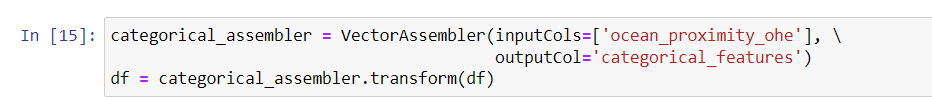


</div>


### Use all data

In [21]:
lr_all = LinearRegression(labelCol='median_house_value', featuresCol='features')

model_all = lr_all.fit(df_train)

22/11/02 21:13:43 WARN Instrumentation: [fbffb347] regParam is zero, which might cause numerical instability and overfitting.
22/11/02 21:13:44 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/02 21:13:44 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/02 21:13:44 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/02 21:13:44 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [23]:
df_test = model_all.transform(df_test)
df_test = df_test.withColumnRenamed('prediction', 'predict_all')

### Use numerical data

In [25]:
lr_num = LinearRegression(labelCol='median_house_value', featuresCol='numerical_features')

model_num = lr_num.fit(df_train)

22/11/02 21:16:33 WARN Instrumentation: [58a25617] regParam is zero, which might cause numerical instability and overfitting.


In [26]:
df_test = model_all.transform(df_test)
df_test = df_test.withColumnRenamed('prediction', 'predict_num')

In [30]:
df_test.select('predict_num', 'predict_all').show(5)

+------------------+------------------+
|       predict_num|       predict_all|
+------------------+------------------+
|103600.00000229171|103600.00000229171|
|50800.000000804066|50800.000000804066|
| 58100.00000070929| 58100.00000070929|
| 68400.00000232933| 68400.00000232933|
|  72200.0000009428|  72200.0000009428|
+------------------+------------------+
only showing top 5 rows



<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Супер, модельки верно обучил)


</div>


## Compare results using RMSE, MAE, R2 metrics

In [26]:
metrics = ['rmse', 'mae', 'r2']
results_columns = ['selection'] + metrics
results = pd.DataFrame(columns=results_columns)

In [32]:
prediction_rows = ['predict_all', 'predict_num']

for prediction_row in prediction_rows:
    out = [prediction_row]
    for metric in metrics:
        evaluator = RegressionEvaluator()
        evaluator.setPredictionCol(prediction_row)
        evaluator.setLabelCol('median_house_value')
        evaluator.setMetricName(metric)
        evaluation = evaluator.evaluate(df_test)
        out.append(evaluation)
    results.loc[len(results)] = out

In [33]:
print(results)

     selection          rmse           mae       r2
0  predict_all  69547.086413  50655.728896  0.63891
1  predict_num  69547.086413  50655.728896  0.63891


## Conclusion

Мне не совсем понятно почему не выявилась разница, нужна помощь

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> Потому что ты перезаписал df_test + используешь одну и ту же модель


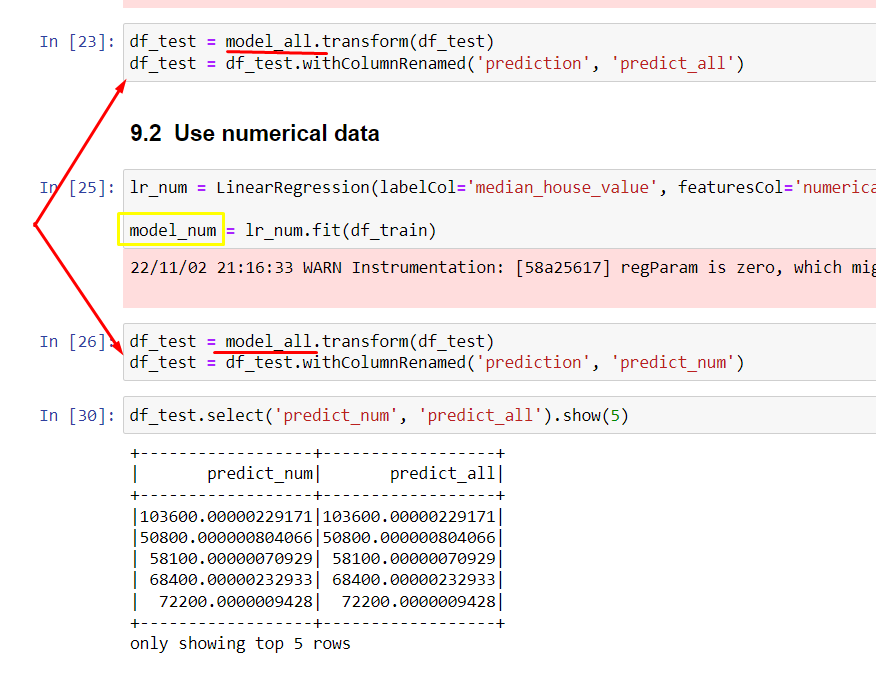
    
    
+  Для второго случая исправь модель
+  И придумай разные названия для того, чтобы сохранить результаты теста

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>  Немного полезного материала:

Немного полезной информации:
+  https://www.tutorialspoint.com/pyspark/index.htm
+  https://www.guru99.com/pyspark-tutorial.html
+  https://databricks.com/spark/getting-started-with-apache-spark/machine-learning#load-sample-data


</div>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Владислав, получился хороший проект! 
    
Если есть  если есть какие либо вопросы я с удовольствием на них отвечу:) <br> Исправь, пожалуйста, замечания и жду проект на следующую проверку:) </div>
